In [23]:
import clean_data_svi as cds
import supervised as sup
import pathlib
import keras_model as km
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from math import sqrt
from datetime import timedelta, datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, LSTM
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, median_absolute_error, roc_curve, auc, f1_score, precision_recall_curve, r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix


In [24]:
SVI_list = []
for i in range(4):
    df = pd.read_csv(f"clean_tables/svi_{i+1}.csv", index_col="date")
    df = df.drop(columns=['Settling_velocity', 'SV_label', 'SVI_label'])
    df.index = pd.to_datetime(df.index, dayfirst=True)
    SVI_list.append(df)

In [25]:
temp_df = pd.read_csv("clean_tables/temperatur.csv", index_col="date")
temp_df.index = pd.to_datetime(temp_df.index, dayfirst=True)
sludge_age_df = pd.read_csv("clean_tables/sludge_age_f_m.csv", index_col="date")
sludge_age_df.index = pd.to_datetime(sludge_age_df.index, dayfirst=True)

In [28]:
reactor_list = []
for i in range(4):
    join = pd.concat([SVI_list[i], temp_df], axis=1)
    if i <=1:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[0, 2]]], axis=1)
    else:
        join = pd.concat([join, sludge_age_df.iloc[:, np.r_[1, 3]]], axis=1)
    months_df = pd.get_dummies(join.index.year, prefix='year')
    months_df.index=join.index
    join = pd.concat([join, months_df], axis=1)
    reactor_list.append(join)

In [34]:
reactor_list[0]

,SVI,Temperature,F_M - A,Sludge Age - A,year_2010,year_2011,year_2012,year_2013,year_2014,year_2015,year_2016,year_2017,year_2018,year_2019,year_2020
date,,,,,,,,,,,,,,,
2010-01-01,90.943683,22.030,0.23,3.44,1,0,0,0,0,0,0,0,0,0,0
2010-01-02,84.365325,21.985,0.18,3.78,1,0,0,0,0,0,0,0,0,0,0
2010-01-03,94.541139,21.740,0.21,3.82,1,0,0,0,0,0,0,0,0,0,0
2010-01-04,97.402597,21.815,0.21,3.40,1,0,0,0,0,0,0,0,0,0,0
2010-01-05,107.937685,21.890,0.23,3.70,1,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-27,166.666667,22.540,0.25,2.75,0,0,0,0,0,0,0,0,0,0,1
2020-12-28,147.453083,22.535,0.26,2.91,0,0,0,0,0,0,0,0,0,0,1
2020-12-29,154.702970,22.660,0.26,2.82,0,0,0,0,0,0,0,0,0,0,1


In [35]:
X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=2, binary=True)

In [36]:
X.shape

(16064, 2, 15)

In [37]:
X[0]

array([[90.94368341, 22.03      ,  0.23      ,  3.44      ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ],
       [84.36532508, 21.985     ,  0.18      ,  3.78      ,  1.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]])

In [38]:
Y[0]

array([1.])

In [43]:
X_normalize, Y_normalize, scalers = km.normalize(X, Y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.10, random_state=42)
model = Sequential()
model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation="sigmoid"))
model.compile(optimizer='adam', loss='binary_crossentropy', 
              metrics=[keras.metrics.BinaryAccuracy(name='binary_accuracy', dtype=None, threshold=0.5)])
model.fit(Xtrain, ytrain, epochs=3, batch_size=10, shuffle=True)


100%|██████████| 10/10 [00:00<00:00, 141.38it/s]


Epoch 1/3
14396/14396 [==============================] - 20s 1ms/step - loss: 0.5655 - binary_accuracy: 0.6908
Epoch 2/3
14396/14396 [==============================] - 16s 1ms/step - loss: 0.5111 - binary_accuracy: 0.7230
Epoch 3/3
14396/14396 [==============================] - 16s 1ms/step - loss: 0.4976 - binary_accuracy: 0.7316


In [60]:
Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)

In [111]:
def threshold_for_max_f1(y_real, y_predict):
    '''
    Given inputs y_real and y_predict, the function returns
    the threshold (rounded to the nearest hundredth) that
    maximizes f1.
    
    Note: this funcnot necessarily optimized, could return to 
    doing this).
    '''
    f1_vals = []
    for i in range(1, 100):
        threshold = i/100
        y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
        y_real = Ytest.astype(int)
        
        f1 = km.results(y_real, y_predict, binary=True)[3]
        f1_vals.append(f1)
    print(f1_vals)
    return (f1_vals.index(max(f1_vals))+1)/100

In [112]:
threshold = threshold_for_max_f1(y_real, y_predict)
y_predict = np.where(Yhat > threshold, 1, 0).astype(int)
y_real = Ytest.astype(int)

[0.007722007722007722, 0.011560693641618497, 0.015384615384615384, 0.022988505747126436, 0.03802281368821293, 0.04914933837429111, 0.04914933837429111, 0.05639097744360902, 0.06367041198501873, 0.07806691449814127, 0.09208103130755066, 0.09506398537477148, 0.10869565217391304, 0.10869565217391304, 0.12567324955116696, 0.13214285714285715, 0.15520282186948853, 0.1681260945709282, 0.1840277777777778, 0.1899827288428325, 0.20240137221269297, 0.22335025380710657, 0.24080267558528431, 0.25412541254125415, 0.26143790849673204, 0.27419354838709675, 0.2852564102564103, 0.3118110236220472, 0.32868217054263565, 0.3460949464012251, 0.350609756097561, 0.36771300448430494, 0.38360175695461196, 0.3819241982507289, 0.3971223021582733, 0.40567375886524826, 0.413986013986014, 0.4408163265306122, 0.4574468085106383, 0.4742268041237113, 0.5012531328320803, 0.5249088699878494, 0.5271867612293145, 0.5393518518518519, 0.5559322033898305, 0.5625692137320044, 0.5736095965103599, 0.5830653804930334, 0.58078141

In [109]:
threshold

0.59

In [110]:
results = km.results(y_real, y_predict, binary=True)
results

(0.714375, 0.6957364341085271, 0.5447647951441578, 0.611063829787234)

In [54]:
classes = ['High_svi', 'Low_svi']

In [55]:
cm = confusion_matrix(y_real, y_predict)

Confusion matrix, without normalization
[[450  66]
 [535 549]]


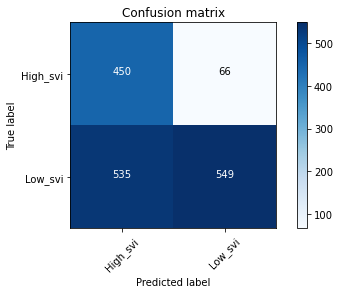

In [56]:
sup.plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [65]:
results = km.results(y_real, y_predict, binary=True)

In [66]:
results

(0.393125, 0.998062015503876, 0.3468013468013468, 0.5147426286856571)

In [20]:
fpr, tpr, thresholds = roc_curve(Ytest, Yhat)

In [21]:
auc(fpr, tpr)

0.8705271651425497

Text(0.5, 1.0, 'ROC curve')

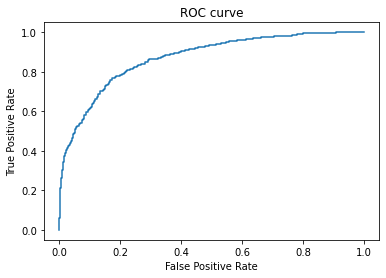

In [22]:
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')

In [135]:
results_list = []
steps_in = 3
steps_out = 4
for i in range(1, steps_in):
    for j in range(1, steps_out):
        X, Y = km.create_join_x_y_arr(reactor_list, n_steps_in=i, n_steps_out=j, binary=True)
        X_normalize, Y_normalize, scalers = km.normalize(X, Y)
        Xtrain, Xtest, ytrain, ytest = train_test_split(X_normalize, Y_normalize, test_size=0.20, random_state=42)
        model = Sequential()
        model.add(LSTM(units=50, activation='relu', name='first_lstm', recurrent_dropout=0.1, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
        model.add(Dense(25, activation='relu'))
        model.add(Dense(1, activation="sigmoid"))
        model.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy')
        model.fit(Xtrain, ytrain, epochs=2, batch_size=10, shuffle=True)
        Yhat, Ytest = km.evaluate(model, Xtest, ytest, scalers, binary=True)
        y_predict = np.rint(Yhat).astype(int)
        y_real = Ytest.astype(int)
        results_list.append(km.results(y_real, y_predict))
    


100%|██████████| 1/1 [00:00<00:00, 167.39it/s]


Epoch 1/2
12854/12854 [==============================] - 7s 512us/step - loss: 0.6406
Epoch 2/2
12854/12854 [==============================] - 5s 375us/step - loss: 0.6121


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 1/1 [00:00<00:00, 177.46it/s]


Epoch 1/2
12851/12851 [==============================] - 8s 595us/step - loss: 0.6453
Epoch 2/2
12851/12851 [==============================] - 5s 377us/step - loss: 0.6154


100%|██████████| 1/1 [00:00<00:00, 223.32it/s]


Epoch 1/2
12848/12848 [==============================] - 7s 528us/step - loss: 0.6468
Epoch 2/2
12848/12848 [==============================] - 5s 392us/step - loss: 0.6145


/Users/sammitchell/Desktop/Mekorot/Project/keras_model.py:93: RuntimeWarning: invalid value encountered in long_scalars
  NPV = (tn) / (tn + fn)
100%|██████████| 2/2 [00:00<00:00, 254.59it/s]


Epoch 1/2
12851/12851 [==============================] - 8s 652us/step - loss: 0.6441
Epoch 2/2
12851/12851 [==============================] - 6s 484us/step - loss: 0.6108


100%|██████████| 2/2 [00:00<00:00, 247.07it/s]


Epoch 1/2
12848/12848 [==============================] - 9s 722us/step - loss: 0.6401
Epoch 2/2
12848/12848 [==============================] - 6s 480us/step - loss: 0.6089


100%|██████████| 2/2 [00:00<00:00, 252.11it/s]


Epoch 1/2
12844/12844 [==============================] - 8s 617us/step - loss: 0.6344
Epoch 2/2
12844/12844 [==============================] - 6s 482us/step - loss: 0.6027


In [136]:
np.shape(results_list)

(6, 4)

In [137]:
(unique, counts) = np.unique(ytrain, return_counts=True)
frequencies = np.asarray((unique, counts)).T

In [138]:
frequencies

array([[0.000e+00, 4.146e+03],
       [1.000e+00, 8.698e+03]])

In [139]:
results_list
'''
[(1, 1),
(1, 2),
(1, 3),
(2, 1),
(2, 2),
(2, 3),]
'''

[(0.6757934038581207, 0.0, nan, nan),
 (0.6890756302521008, 0.001, 1.0, 0.0019980019980019984),
 (0.6843088418430884, 0.0, nan, nan),
 (0.6890756302521008, 0.001, 1.0, 0.0019980019980019984),
 (0.6889788293897883, 0.014792899408284023, 1.0, 0.029154518950437316),
 (0.686799501867995, 0.016617790811339198, 1.0, 0.032692307692307694)]

In [151]:
results_list = [(0.6757934038581207, 0.0, 0, 0),
 (0.6890756302521008, 0.001, 1.0, 0.0019980019980019984),
 (0.6843088418430884, 0.0, 0, 0),
 (0.6890756302521008, 0.001, 1.0, 0.0019980019980019984),
 (0.6889788293897883, 0.014792899408284023, 1.0, 0.029154518950437316),
 (0.686799501867995, 0.016617790811339198, 1.0, 0.032692307692307694)]

In [159]:
#plot graph of a metric result for all n_step_in and n_step_out values
x=list(range(1, steps_out))
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(4):
    for i in range(steps_in-1):
        y=[]
        for j in range(steps_out-1):
            y.append(results_list[i*(steps_out-1):i*(steps_out-1) + (steps_out-1)][j][z])
        plt.plot(x, y, label=f'n_steps_in={i+1}')
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel(label[z])
    plt.title("Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' ")
    plt.savefig(f"figures/Simple LSTM {label[z]}.png", bbox_inches="tight")
    plt.close()

In [163]:
#plot graph of all metric results for a n_step_in value
x=list(range(1, steps_out))
label = ['accuracy', 'TNR', 'NPV', 'f1']
for z in range(steps_in-1):
    for i in range(4):
        y=[]
        for j in range(steps_out-1):
            y.append(results_list[z*(steps_out-1):z*(steps_out-1)+(steps_out-1)][j][i])
        plt.plot(x, y, label=label[i])
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.xlabel("n_steps_out")
    plt.ylabel('Metric value')
    plt.title(f"Simple LSTM, 3 layers (50,25,1),\n name='first_lstm', recurrent_dropout=0.1 \n optimizer='adam', loss='binary_crossentropy' \n n_steps_in={z+1} ")
    plt.savefig(f"figures/Simple_LSTM/Simple LSTM n_steps_in={z+1}.png", bbox_inches="tight")
    plt.close()